In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-4f53211e-ceab-5aa7-b0ba-6ef87e62c8ed
# %env LD_LIBRARY_PATH=/home/ubuntu/miniconda3/envs/sab_env2/lib/python3.12/site-packages/nvidia/nvjitlink/lib/:$LD_LIBRARY_PATH
%env CUDA_VISIBLE_DEVICES

env: CUDA_VISIBLE_DEVICES=MIG-4f53211e-ceab-5aa7-b0ba-6ef87e62c8ed


'MIG-4f53211e-ceab-5aa7-b0ba-6ef87e62c8ed'

In [2]:
import json
import random
from datetime import datetime
from pathlib import Path

import monai
import numpy as np
import SimpleITK as sitk
import torch
from matplotlib import pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.notebook import tqdm

import cfg
from funcs import * 
from models.sam.utils.transforms import ResizeLongestSide

# from .utils.transforms import ResizeLongestSide

/home/ubuntu/Thesis_code/models/sam/modeling/tiny_vit_sam.py:677: UserWarning: Overwriting tiny_vit_5m_224 in registry with models.sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/ubuntu/Thesis_code/models/sam/modeling/tiny_vit_sam.py:677: UserWarning: Overwriting tiny_vit_11m_224 in registry with models.sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/ubuntu/Thesis_code/models/sam/modeling/tiny_vit_sam.py:677: UserWarning: Overwriting tiny_vit_21m_224 in registry with models.sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/ubuntu/Thesis_code/mo

In [7]:
mask_sacrum_volume()

TypeError: mask_sacrum_volume() missing 2 required positional arguments: 'image' and 'mask'

In [3]:
!nvidia-smi --list-gpus

GPU 0: NVIDIA A100 80GB PCIe (UUID: GPU-c3316689-3235-53a1-8d30-24494d5868b9)
  MIG 3g.40gb     Device  0: (UUID: MIG-51be5228-6c6d-56ad-ae45-a73071efd76a)
  MIG 2g.20gb     Device  1: (UUID: MIG-4f53211e-ceab-5aa7-b0ba-6ef87e62c8ed)
  MIG 1g.10gb     Device  2: (UUID: MIG-079b883d-bd08-5403-a958-cf1024f9dd0f)
  MIG 1g.10gb     Device  3: (UUID: MIG-564785c9-6926-50a7-8466-531d8603d411)
GPU 1: NVIDIA A100 80GB PCIe (UUID: GPU-e8dbd37f-2dc8-242c-e88a-814728409060)
  MIG 7g.80gb     Device  0: (UUID: MIG-3b133eb8-ed94-51f8-937f-cbc3e3f3ff2a)


In [4]:
import torch

print(torch.cuda.is_available())

True


In [17]:
class MRI_dataset_batched(Dataset):
    def __init__(
        self,
        args,
        data_file: Path,
        batch_size: int = 20,
        phase: str = "train",
        operation_mode: str = "queue",  # ["queue" or "single"]
        mask_out_size: int = 256,
        attention_size: int = 64,
        channel_num: int = 1,
        crop: bool = False,
        crop_size: int = 1024,
        targets: list[str,] = ["femur", "hip"],
        cls: int = 1,
        if_prompt: bool = False,
        prompt_type: str = "point",
        if_attention_map: bool | None = None,
        device: str = "cpu",
    ):
        # TODO:
        super().__init__()
        self.batch_size = batch_size
        self.phase = phase
        self.operation_mode = operation_mode
        self.mask_out_size = mask_out_size
        self.attention_size = attention_size
        self.crop = crop
        self.crop_size = crop_size
        self.channel_num = channel_num
        self.targets = targets
        self.args = args
        self.cls = cls
        self.if_prompt = if_prompt
        self.prompt_type = prompt_type
        self.if_attention_map = if_attention_map
        self.device = device

        self.data_dict = json.load(open(data_file, "r"))
        self.images_list = list(self.data_dict.keys())
        # self.transform_normalize = transforms.Normalize(
        #     mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        # )
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
        self.queue = self._create_queue()

        if phase == "train":
            self.aug_img = [
                transforms.RandomEqualize(p=0.1),
                transforms.ColorJitter(
                    brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3
                ),
                transforms.RandomAdjustSharpness(0.5, p=0.5),
            ]
            self.transform_spatial = transforms.Compose(
                [
                    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.2)),
                    transforms.RandomRotation(45),
                ]
            )
            transform_img = [transforms.ToTensor()]
        else:
            transform_img = [transforms.ToTensor()]
        self.transform_img = transforms.Compose(transform_img)

    def __len__(self):
        if self.operation_mode == "queue":
            # return  based on queue size
            data_len = len(self.queue) // self.batch_size
            if len(self.queue) % self.batch_size != 0:
                data_len += 1
        else:
            # return number of image volumes
            data_len = len(self.images_list)

        return data_len

    def get_que_batch(self, index: int):
        start_index = index * self.batch_size
        end_index = start_index + self.batch_size
        if end_index >= len(self.queue):
            batch_tuples = self.queue[start_index:]
        else:
            batch_tuples = self.queue[start_index:end_index]

        grouped = {}
        for name, slice in batch_tuples:
            if name in grouped:
                grouped[name].append(slice)
            else:
                grouped[name] = [slice]
        volume_data = []
        for name, slices in grouped.items():
            the_dict = self.data_dict[name].copy()
            the_dict["slices"] = slices
            volume_data.append(the_dict)

        if len(batch_tuples) == 0:
            print(
                f"mri index overshoot, calling {index} start {start_index}, end {end_index}, total {len(self.queue)}"
            )

        for i, vol in enumerate(volume_data):
            data = self._process_volume(vol)
            if i == 0:
                loaded_batch = data
                # start of each image volume if concatenated
                loaded_batch["cat_indexes"] = [0]
            else:
                loaded_batch["cat_indexes"].append(loaded_batch["images"].shape[0])
                for key in data.keys():
                    if key in ["images", "masks", "atten_maps"]:
                        loaded_batch[key] = torch.cat([loaded_batch[key], data[key]], dim=0)
                    else:
                        loaded_batch[key] = loaded_batch[key] + data[key]

        return loaded_batch

    def _create_queue(self) -> list[tuple]:
        queue = []
        for img in self.images_list:
            for slice_num in self.data_dict[img]["slices"]:
                queue.append((img, slice_num))
        return queue

    def _process_volume(self, sample: dict) -> dict:
        out_dict = {}
        img_path = Path(sample["image_path"])
        mask_path = Path(sample["mask_path"])
        slices = [int(x) for x in sample["slices"]]  # all slices for this image
        attentions = sample["attention_path"]
        if self.if_attention_map:
            assert all([Path(x).is_file() for x in attentions.values()])
        if img_path.is_file():
            img_vol = np.array(
                sitk.GetArrayFromImage(sitk.ReadImage(img_path)), dtype=float
            )
            img_vol = np.array(
                (img_vol - img_vol.min())
                / (img_vol.max() - img_vol.min() + 1e-8)
                * 255,
                dtype=np.uint8,
            )
        else:
            print(f"Error reading the image {img_path}")

        if mask_path.is_file():
            msk = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
        else:
            print(f"Error reading the mask {mask_path}")

        out_dict["slices"] = slices
        out_dict["original_size"] = [sample["original_size"]]
        out_dict["image_name"] = [img_path.name]

        output_attention = torch.zeros(
            (len(slices), self.attention_size, self.attention_size)
        )
        smallest_dimension_index = np.argmin(img_vol.shape)
        img_vol = (
            torch.from_numpy(
                np.take(img_vol, indices=slices, axis=smallest_dimension_index)
            )
            .to(self.device)
            .to(torch.float32)
        )
        msk = torch.from_numpy(
            np.take(msk, indices=slices, axis=smallest_dimension_index)
        ).to(self.device)
        if smallest_dimension_index != 0:
            img_vol = torch.moveaxis(img_vol, smallest_dimension_index, 0)
            msk = torch.moveaxis(msk, smallest_dimension_index, 0)
        img_vol = img_vol.unsqueeze(1).repeat(1, 3, 1, 1)
        msk = msk.unsqueeze(1)
        img_vol = ResizeLongestSide(
            target_length=self.args.image_size
        ).apply_image_torch(img_vol)
        img_vol = img_vol.to(torch.uint8)
        msk = self.resize_mask(msk, size=(img_vol.shape[2], img_vol.shape[3]))
        img_vol = self.pad(img_vol, size=self.args.image_size)
        msk = self.pad(msk, size=self.args.image_size)

        if self.crop:
            img_vol = self.pad(img_vol, size=self.args.crop_size)
            msk = self.pad(msk, size=self.args.crop_size)
            for i in range(img_vol.shape[0]):
                t, l, h, w = transforms.RandomCrop.get_params(
                    img_vol[i], (self.crop_size, self.crop_size)
                )
                img_vol[i] = transforms.functional.crop(img_vol[i], t, l, h, w)
                msk[i] = transforms.functional.crop(msk[i], t, l, h, w)

        if self.phase == "train":
            # add random optimazition
            for i in range(img_vol.shape[0]):
                aug_img_fuc = transforms.RandomChoice(self.aug_img)
                img_vol[i] = aug_img_fuc(img_vol[i])
                random_transform = monai.transforms.OneOf(
                    [
                        monai.transforms.RandGaussianNoise(prob=0.5, mean=0.0, std=0.1),
                        monai.transforms.RandKSpaceSpikeNoise(
                            prob=0.5, intensity_range=None, channel_wise=True
                        ),
                        monai.transforms.RandBiasField(degree=3),
                        monai.transforms.RandGibbsNoise(prob=0.5, alpha=(0.0, 1.0)),
                    ],
                    weights=[0.3, 0.3, 0.2, 0.2],
                )
                img_vol[i] = random_transform(img_vol[i]).as_tensor()
        else:
            adjust_contrast = monai.transforms.AdjustContrast(gamma=0.8)
            for i in range(img_vol.shape[0]):
                if img_vol[i].float().mean() < 0.05:
                    img_vol[i] = min_max_normalize(img_vol[i])
                    img_vol[i] = adjust_contrast(img_vol[i])
        if "all" in self.targets:  # combine all targets as single target
            msk = (msk > 0).to(torch.int)
        else:
            msk = msk.to(torch.int)
        mask_cls = (msk == self.cls).to(torch.float32)
        img_vol = img_vol.to(torch.float32)

        img_vol = (img_vol - img_vol.min()) / (img_vol.max() - img_vol.min() + 1e-8)
        img_vol = mask_sacrum_volume(image=img_vol, mask=mask_cls)

        if self.if_attention_map:
            for i in range(len(slices)):
                output_attention[i] = torch.from_numpy(
                    np.load(attentions[str(slices[i])])
                )
            output_attention = output_attention.to(self.device)

        if self.phase == "train" and (not self.if_attention_map == None):
            mask_cls = mask_cls.repeat(1, 3, 1, 1)
            attention_large = output_attention.unsqueeze(1).repeat(1, 3, 1, 1)
            attention_large = transforms.functional.resize(
                attention_large, self.args.image_size
            )
            for i in range(img_vol.shape[0]):
                # both_targets = torch.cat((img_vol[i].unsqueeze(0), mask_cls[i].unsqueeze(0)), 0)
                all_targets = torch.cat(
                    (
                        img_vol[i : i + 1],
                        mask_cls[i : i + 1],
                        attention_large[i : i + 1],
                    ),
                    0,
                )
                transformed_targets = self.transform_spatial(all_targets)
                img_vol[i] = transformed_targets[0]
                mask_cls[i] = transformed_targets[1].to(torch.int).to(torch.float32)
                output_attention[i] = transforms.functional.resize(
                    transformed_targets[2], self.attention_size
                )[0, :, :]
            mask_cls = mask_cls[:, 0:1, :, :]
        # transform normalize
        img_vol = (img_vol - self.mean) / self.std

        out_dict["images"] = img_vol
        out_dict["masks"] = mask_cls
        out_dict["atten_maps"] = output_attention

        return out_dict
    
    def add_point_prompt(self, batch):
        images = batch["images"] 
        masks = batch["masks"]
        mask_size = masks.shape[-2:]
        if mask_size != images.shape[-2:]:
            masks = self.resize_mask(masks, images.shape[-2:])
        _, points, masks = generate_click_prompt(images, masks)
        point_labels = torch.ones(masks.size(0), 1, dtype=torch.int, device=self.device)
        if mask_size != images.shape[-1]:
            masks = self.resize_mask(masks, mask_size)
        batch["points"] = points.unsqueeze(1)
        batch["point_labels"] = point_labels
        batch["masks"] = masks
        return batch

    def inverse_normalize(self, tensor: torch.Tensor) -> torch.Tensor:
        return tensor.mul(self.std).add(self.mean)

    def resize_mask(self, mask_tensor: torch.Tensor, size: tuple) -> torch.Tensor:
        """
            Resizes a batch of CxHxW tensors using the nearest neighbor method.
        Args:
            mask_tensor (torch.Tensor): Input tensor of shape (batch, channel, height, width).
            size (tuple): Target size as a tuple (new_height, new_width).
        Returns:
            torch.Tensor: Resized batch of tensor of shape (batch, channel, height, width).
        """
        new_height, new_width = size
        batch, channel, original_height, original_width = mask_tensor.shape
        # Calculate the ratio of the old dimensions to the new dimensions
        row_ratio, col_ratio = original_height / new_height, original_width / new_width
        # Create the new index arrays for the resized image
        row_indices = (
            torch.arange(new_height, device=mask_tensor.device) * row_ratio
        ).long()
        col_indices = (
            torch.arange(new_width, device=mask_tensor.device) * col_ratio
        ).long()
        row_indices = row_indices.unsqueeze(1).repeat(1, new_width)
        col_indices = col_indices.unsqueeze(0).repeat(new_height, 1)
        resized_mask_tensor = mask_tensor[:, :, row_indices, col_indices]

        return resized_mask_tensor

    def pad(self, images: torch.Tensor, size: int) -> torch.Tensor:
        """
            Pads a batch of CxHxW torch.Tensors to a specified size.
        Args:
            images (torch.Tensor): Input tensor of shape (batch, channel, height, width).
            size (int): Target size to pad the images to.
        Returns:
            torch.Tensor: Padded batch of images.
        """
        batch, channel, im_h, im_w = images.shape
        diff_w = max(0, size - im_w)
        diff_h = max(0, size - im_h)

        padding = (
            diff_w // 2,
            diff_h // 2,
            diff_w - diff_w // 2,
            diff_h - diff_h // 2,
        )
        padded_images = torch.zeros(
            (batch, channel, size, size), dtype=images.dtype, device=images.device
        )
        # Calculate the indices for placing the original images in the padded tensor
        padded_images[
            :, :, padding[1] : padding[1] + im_h, padding[0] : padding[0] + im_w
        ] = images

        return padded_images

    def __getitem__(self, index) -> dict:
        # Generate random click points
        if self.operation_mode == "queue":
            batch = self.get_que_batch(index)
        else:
            sample = self.data_dict[self.images_list[index]]
            batch = self._process_volume(sample)

        if self.if_prompt and torch.bernoulli(torch.tensor([self.args.prompt_probability])).bool().item():
            if self.prompt_type == "points":
                batch = self.add_point_prompt(batch)
        if batch["masks"].shape[-1] != self.mask_out_size:
            batch["masks"] = self.resize_mask(batch["masks"], (self.mask_out_size, self.mask_out_size))

        return batch

    def on_epoch_end(self):
        random.shuffle(self.images_list)
        self.queue = self._create_queue()

In [8]:
args = cfg.parse_args()
args.if_mask_decoder_adapter = True
args.if_encoder_adapter = True
args.decoder_adapt_depth = 2

device = "cuda:0" if torch.cuda.is_available() else "cpu"
IMGS_PATH = Path("./images")
MASKS_PATH = Path("./masks")
test_data_path = "Test_data_files_resampled.json"
train_data_path = "Train_data_files_resampled.json"
test_data_file = json.load(open(test_data_path, "r"))
train_data_file = json.load(open(train_data_path, "r"))

In [ ]:
sample = test_data_file[list(test_data_file.keys())[0]]
att = sample["attention_path"][list(sample["attention_path"])[7]]
att = np.load(att)
plt.imshow(att)
plt.show()

In [18]:
mris_batched = MRI_dataset_batched(
    args,
    data_file=train_data_path,
    batch_size=40,
    phase="train",
    operation_mode="queue",
    attention_size=64,
    mask_out_size =512,
    channel_num=1,
    crop=False,
    crop_size=1024,
    targets=["all"],
    if_attention_map=True,
    if_prompt=True,
    prompt_type="points",
    device=device,
)

In [28]:
ret_vol = mris_batched._process_volume(mris_batched.data_dict[mris_batched.images_list[5]], if_points=True)
ret_vol["images"].shape

torch.Size([17, 3, 1024, 1024])

In [21]:
data = mris_batched[2]
print(data.keys())
print(data["original_size"], data["image_name"])

dict_keys(['slices', 'original_size', 'image_name', 'images', 'masks', 'atten_maps', 'cat_indexes'])
[[385, 384], [389, 386], [486, 483]] ['2_t2.nii.gz', '3_t1.nii.gz', '3_t2.nii.gz']


name 9_t2.nii.gz 16 (1024, 1024, 1) orig_size [610, 603]


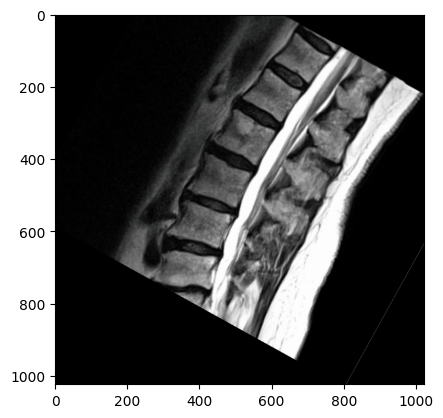

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.7404747].


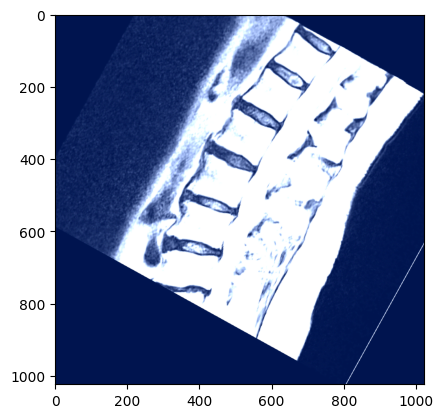

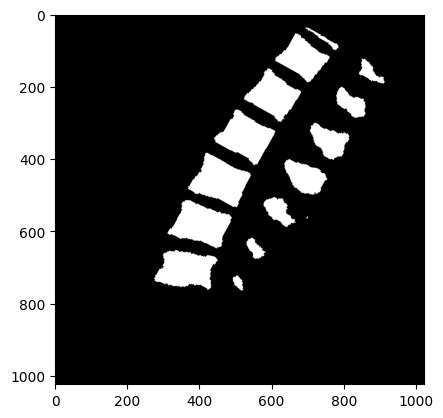

In [77]:
n = 8
img_norm =  data["images"][n : n + 1]

img = (mris_batched.inverse_normalize(img_norm).cpu().numpy()[0] * 255.0).astype(np.uint8)
msk = (np.moveaxis(data["masks"][n].cpu().numpy(), 0, -1)).astype(np.uint8)
img = np.moveaxis(img, 0, -1)
img_norm = np.moveaxis(img_norm[0].cpu().numpy(), 0, -1)
img_norm = img_norm - np.min(img_norm) if np.min(img_norm) < 0 else img_norm
print(
    "name",
    data["img_name"],
    len(data["images"]),
    msk.shape,
    "orig_size",
    data["original_size"],
)
plt.imshow(np.flipud(img), cmap="gray", vmin=np.min(img), vmax=np.max(img))
plt.show()
plt.imshow(np.flipud(img_norm), vmin=np.min(img_norm), vmax=np.max(img_norm))
plt.show()
plt.imshow(np.flipud(msk), cmap="gray", vmin=np.min(msk), vmax=np.max(msk))
plt.show()

In [23]:
img_pth = Path("/data/sab_data/images/5_t2.nii.gz")
mask_pth = Path("/data/sab_data/masks/5_t2.nrrd")
print(img_pth.name)
n = 9
img_direct = np.array(sitk.GetArrayFromImage(sitk.ReadImage(img_pth)), dtype=float)
mask_direct = sitk.GetArrayFromImage(sitk.ReadImage(mask_pth))
print(img_direct.shape, mask_direct.shape)
smallest_dimension_index = np.argmin(img_direct.shape)
img_direct = torch.from_numpy(img_direct)
mask_direct = torch.from_numpy(mask_direct)
if smallest_dimension_index != 0:
    img_direct = torch.moveaxis(img_direct, smallest_dimension_index, 0)
    mask_direct = torch.moveaxis(mask_direct, smallest_dimension_index, 0)

mask_summed_0 = (sum_along_axis(mask_direct, 0) > 0).to(torch.int)
mask_summed_1 = (sum_along_axis(mask_direct, 1) > 0).to(torch.int)
mask_summed_2 = (sum_along_axis(mask_direct, 2) > 0).to(torch.int)

image_masked = mask_unwanted(image=img_direct, mask=mask_direct)[n]
# ori_img,pred_1,voxel_spacing1,Pil_img1,slice_id1 = evaluate_1_volume_withattention(bs,sam_fine_tune,device,slice_id=10,atten_map=batch["atten_map"])

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(mask_summed_0, origin='lower')
axs[0].set_title("mask_summed_0")
axs[0].axis("off")
axs[1].imshow(mask_direct[n],origin='lower')
axs[1].set_title("mask_direct")
axs[1].axis("off")
axs[2].imshow(img_direct[n], origin='lower', cmap="gray")
axs[2].set_title("img_direct")
axs[2].axis("off")
axs[3].imshow(image_masked, origin='lower')
axs[3].set_title("image_masked")
axs[3].axis("off")
plt.tight_layout()
plt.show()


5_t2.nii.gz
(17, 512, 512) (17, 512, 512)


NameError: name 'mask_unwanted' is not defined

(19, 610, 603) (19, 610, 603)


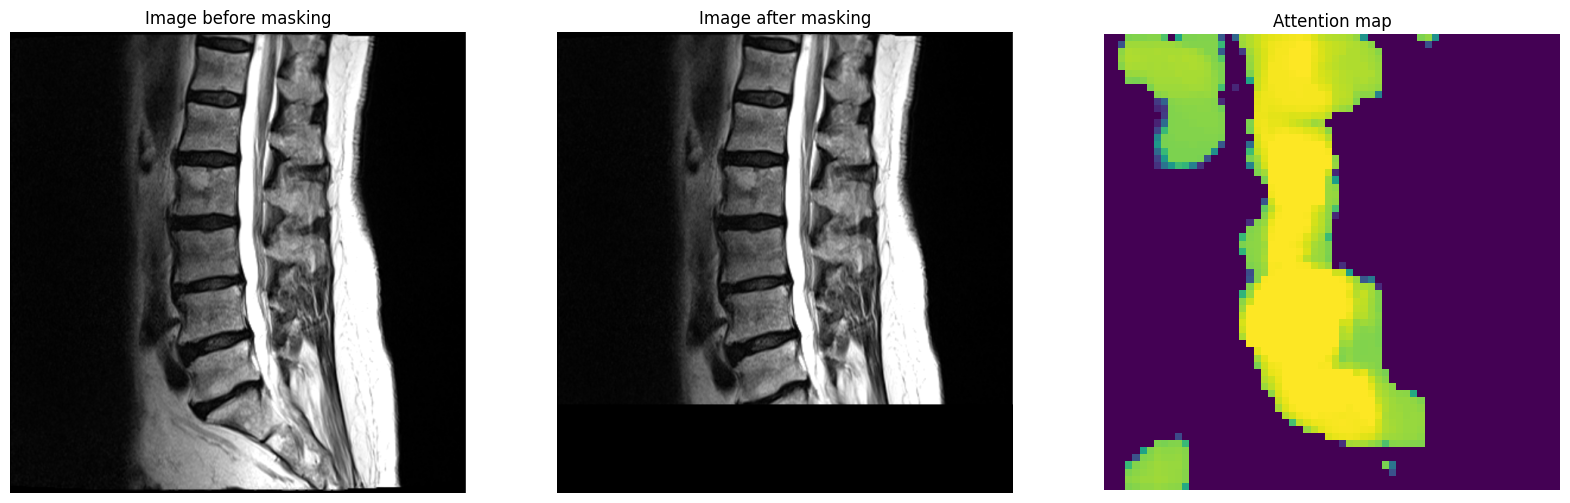

In [26]:
n = 9
img_pth = Path("/data/sab_data/images/resampled/9_t2.nii.gz")
mask_pth = Path("/data/sab_data/masks/resampled/9_t2.nrrd")
atten = np.load(Path(f"/data/sab_data/images/resampled/attention_maps/9_t2-{n}.npy"))

img_direct = np.array(sitk.GetArrayFromImage(sitk.ReadImage(img_pth)), dtype=float)
img_direct = (img_direct - img_direct.min()) / (img_direct.max() - img_direct.min() + 1e-8)
mask_direct = sitk.GetArrayFromImage(sitk.ReadImage(mask_pth))
print(img_direct.shape, mask_direct.shape)
smallest_dimension_index = np.argmin(img_direct.shape)
img_direct = torch.from_numpy(img_direct)
mask_direct = torch.from_numpy(mask_direct)
if smallest_dimension_index != 0:
    img_direct = torch.moveaxis(img_direct, smallest_dimension_index, 0)
    mask_direct = torch.moveaxis(mask_direct, smallest_dimension_index, 0)

image_masked = mask_unwanted(image=img_direct, mask=mask_direct)[n]
image_masked = image_masked.flipud()
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(img_direct[n].flipud(), cmap="gray")
axs[0].set_title("Image before masking")
axs[0].set_axis_off()
axs[1].imshow(image_masked, cmap="gray")
axs[1].set_title("Image after masking")
axs[1].set_axis_off()
axs[2].imshow(np.flipud(atten))
axs[2].set_title("Attention map")
axs[2].set_axis_off()
plt.show()

In [77]:
with_space_dict = {key: value for key, value in mris_batched.data_dict.items() if 'SPACE' in key} 
no_space_dict = {key: value for key, value in mris_batched.data_dict.items() if 'SPACE' not in key} 
mris_batched.data_dict = with_space_dict
mris_batched.images_list = list(mris_batched.data_dict.keys())
# plt.imshow(img_direct)
# plt.show()

In [33]:
from predict_funs import drawContour
import cv2
img_pth = Path("/data/sab_data/images/resampled/2_t1.nii.gz")
mask_pth = Path("/data/sab_data/masks/resampled/2_t1.nrrd")
print(img_pth.name)
n = 20
img_direct = np.array(sitk.GetArrayFromImage(sitk.ReadImage(img_pth)), dtype=float)
mask_direct = sitk.GetArrayFromImage(sitk.ReadImage(mask_pth))
print(img_direct.shape, mask_direct.shape)
smallest_dimension_index = np.argmin(img_direct.shape)
if smallest_dimension_index != 0:
    img_direct = np.moveaxis(img_direct, smallest_dimension_index, 0)
    mask_direct = np.moveaxis(mask_direct, smallest_dimension_index, 0)
img_direct = (img_direct - img_direct.min()) / (img_direct.max() - img_direct.min() + 1e-8) 


2_t1.nii.gz
(17, 322, 320) (17, 322, 320)


uint8 uint8


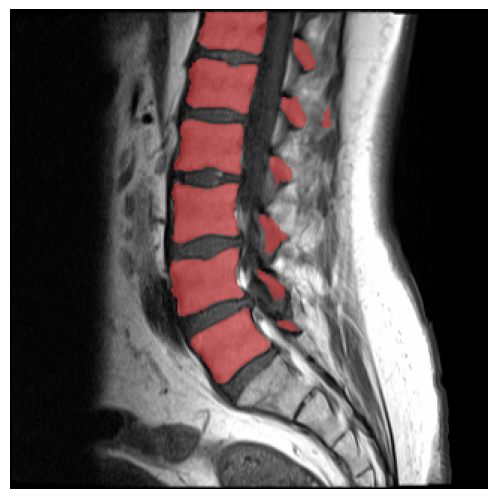

In [46]:
n = 7
target_prediction =  [210,50,50]   
slice = cv2.flip(img_direct.copy()[n], 0)
slice = np.repeat(np.array(slice*255,dtype=np.uint8).copy()[:, :, np.newaxis], 3, axis=2)
msk = np.flipud(mask_direct[n]) * 255
print(slice.dtype, np.flipud(slice).dtype)
# ratio = int(255/np.max(slice))
# msk = np.uint(msk*ratio)
mask_mixed = drawContour(slice, msk,target_prediction,size=-1,a=0.6)

fig,ax = plt.subplots(1)

# Set whitespace to 0
fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

ax.margins(x=0)
ax.imshow(mask_mixed,cmap='gray',vmin=0, vmax=255)
ax.axis("off")
plt.margins(0,0)
plt.savefig("filename.png", bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

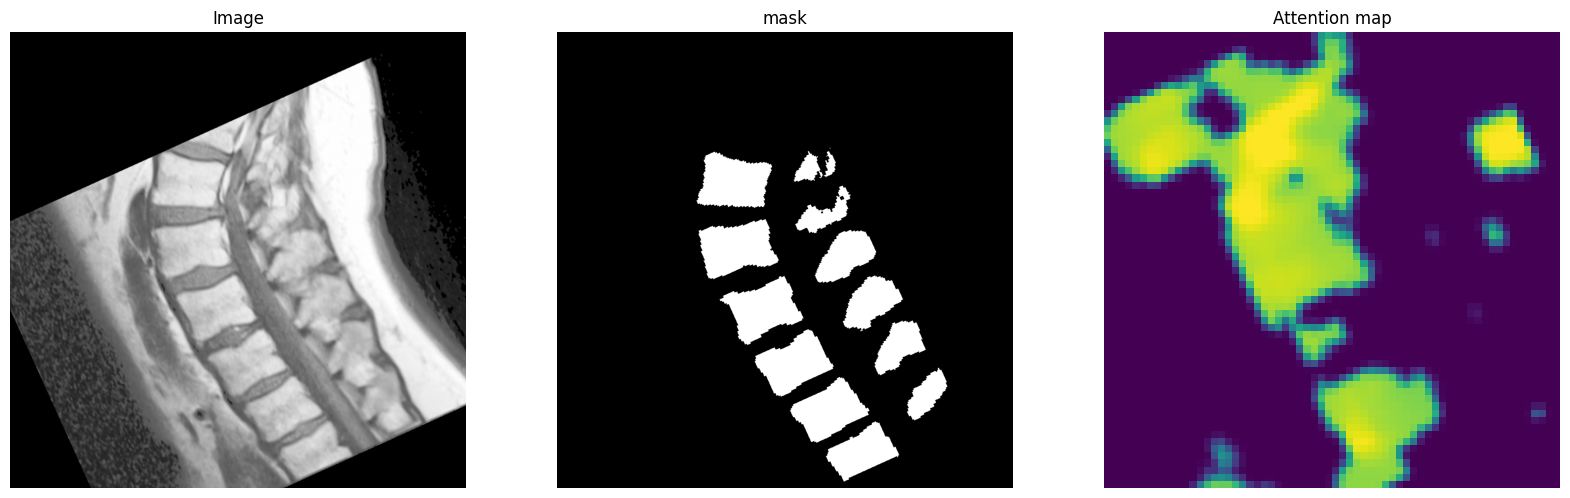

In [24]:
data_sample = mris_batched[2]
n= 8
imgs = mris_batched.inverse_normalize(data_sample["images"]).cpu().numpy() * 255.0
imgs = np.moveaxis(imgs, 1, -1).astype(np.uint8)
msks = np.moveaxis(data_sample["masks"].cpu().numpy(), 1, -1).astype(np.uint8)
attens = data_sample["atten_maps"].cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(imgs[n], cmap="gray")
axs[0].set_title("Image")
axs[0].set_axis_off()
axs[1].imshow(msks[n], cmap="gray")
axs[1].set_title("mask")
axs[1].set_axis_off()
axs[2].imshow(attens[n])
axs[2].set_title("Attention map")
axs[2].set_axis_off()
plt.show()

In [24]:
mris_batched[0].keys()

dict_keys(['images', 'masks', 'img_name', 'slices', 'original_size', 'atten_map'])

In [31]:
#Test mris_batched
print(len(mris_batched))

start_time = datetime.now()
with tqdm(total=len(mris_batched)) as pbar:
    for ind, batch in enumerate(mris_batched):
        pbar.write(
            f"batch {ind} from {len(mris_batched)}: length {len(batch['images'])}"
        )
        pbar.update(1)
        # break

end_time = datetime.now()
print(
    "start_time:", start_time, " end_time:", end_time, " diff:", end_time - start_time
)

90


  0%|          | 0/90 [00:00<?, ?it/s]

batch 0 from 90: length 30
batch 1 from 90: length 115
batch 2 from 90: length 15
batch 3 from 90: length 20
batch 4 from 90: length 19
batch 5 from 90: length 15
batch 6 from 90: length 24
batch 7 from 90: length 24
batch 8 from 90: length 15
batch 9 from 90: length 24
batch 10 from 90: length 24
batch 11 from 90: length 108
batch 12 from 90: length 25
batch 13 from 90: length 25
batch 14 from 90: length 24
batch 15 from 90: length 24
batch 16 from 90: length 17
batch 17 from 90: length 17
batch 18 from 90: length 24
batch 19 from 90: length 19
batch 20 from 90: length 114
batch 21 from 90: length 18
batch 22 from 90: length 19
batch 23 from 90: length 18
batch 24 from 90: length 24
batch 25 from 90: length 24
batch 26 from 90: length 15
batch 27 from 90: length 14
batch 28 from 90: length 23
batch 29 from 90: length 17
batch 30 from 90: length 17
batch 31 from 90: length 15
batch 32 from 90: length 17
batch 33 from 90: length 24
batch 34 from 90: length 19
batch 35 from 90: length 17

In [79]:
class MRI_dataset(Dataset):
    def __init__(
        self,
        args,
        img_folder: Path,
        mask_folder: Path,
        data_file: Path,
        phase="train",
        # sample_num=50,
        attention_size=64,
        channel_num=1,
        crop=False,
        crop_size=1024,
        targets=["femur", "hip"],
        # part_list=["all"],
        cls=1,
        if_prompt=True,
        prompt_type="point",
        region_type="largest_15",
        prompt_num=15,
        # delete_empty_masks=False,
        if_attention_map=None,
    ):
        super().__init__()
        self.img_folder = img_folder
        self.mask_folder = mask_folder
        self.attention_size = attention_size
        self.crop = crop
        self.crop_size = crop_size
        self.phase = phase
        self.channel_num = channel_num
        self.targets = targets
        # self.segment_names_to_labels = []
        self.args = args
        self.cls = cls
        self.if_prompt = if_prompt
        self.region_type = region_type
        self.prompt_type = prompt_type
        self.prompt_num = prompt_num
        self.if_attention_map = if_attention_map

        # for i,tag in enumerate(targets):
        #     self.segment_names_to_labels.append((tag,i))

        self.data_dict = json.load(open(data_file, "r"))
        self.images_list = list(self.data_dict.keys())

        self.transform_normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )

        if phase == "train":
            self.aug_img = [
                transforms.RandomEqualize(p=0.1),
                transforms.ColorJitter(
                    brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3
                ),
                transforms.RandomAdjustSharpness(0.5, p=0.5),
            ]
            self.transform_spatial = transforms.Compose(
                [
                    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.2)),
                    transforms.RandomRotation(45),
                ]
            )
            transform_img = [transforms.ToTensor()]
        else:
            transform_img = [transforms.ToTensor()]
        self.transform_img = transforms.Compose(transform_img)

    def __len__(self):
        data_len = 0
        # return number of available slices
        # for img in self.images_list:
        #     data_len += len(self.data_dict[img]["slices"])

        # return number of image volumes
        data_len = len(self.images_list)
        return data_len

    def resize_mask(self, mask_array: np.array, size: tuple):
        """Resizes W*H array using nearest neighbor method"""
        new_height, new_width = size
        # Get the original dimensions
        original_height, original_width = mask_array.shape
        # Calculate the ratio of the old dimensions to the new dimensions
        row_ratio, col_ratio = original_height / new_height, original_width / new_width
        # Create an empty array for the resized image
        resized_image_array = np.zeros((new_height, new_width), dtype=mask_array.dtype)
        # Populate the resized image array using nearest-neighbor interpolation
        for i in range(new_height):
            for j in range(new_width):
                original_i = int(i * row_ratio)
                original_j = int(j * col_ratio)
                resized_image_array[i, j] = mask_array[original_i, original_j]
        return resized_image_array

    def pad(self, image: Image, size: int):
        # image: WxHxC if PIL image
        # or HxW if torch.Tensor
        if isinstance(image, Image.Image):
            im_w, im_h = image.size[0:2]
        else:
            im_h, im_w = image.shape[0:2]
        diff_w = max(0, size - im_w)
        diff_h = max(0, size - im_h)
        padding = (
            diff_w // 2,
            diff_h // 2,
            diff_w - diff_w // 2,
            diff_h - diff_h // 2,
        )
        image = transforms.functional.pad(image, padding, 0, "constant")
        return image

    def __getitem__(self, index):
        # load image and the mask
        sample = self.data_dict[self.images_list[index]]
        img_path = Path(sample["image_path"])
        mask_path = Path(sample["mask_path"])
        slices = [int(x) for x in sample["slices"]]  # all slices for this image
        attentions = sample["attention_path"]
        if self.if_attention_map:
            assert all([Path(x).is_file() for x in attentions.values()])
        # print(img_path,mask_path)
        if img_path.is_file():
            img_vol = np.array(
                sitk.GetArrayFromImage(sitk.ReadImage(img_path)), dtype=float
            )
            img_vol = np.array(
                (img_vol - img_vol.min())
                / (img_vol.max() - img_vol.min() + 1e-8)
                * 255,
                dtype=np.uint8,
            )
            # img_3c = np.tile(img_arr[:, :, None], [1, 1, 3])
            # img_vol = Image.fromarray(img_3c, "RGB")
            # img = Image.open(img_path).convert("RGB")
        else:
            print(f"Error reading the image {img_path}")

        if mask_path.is_file():
            msk = np.array(sitk.GetArrayFromImage(sitk.ReadImage(mask_path)))
            # msk = Image.fromarray(msk, "L")
        else:
            print(f"Error reading the mask {mask_path}")
        output_image = torch.zeros(
            (len(slices), 3, self.args.image_size, self.args.image_size)
        )
        output_mask = torch.zeros(
            (len(slices), 1, self.args.image_size, self.args.image_size)
        )
        output_attention = torch.zeros(
            (len(slices), self.attention_size, self.attention_size)
        )
        smallest_dimension_index = np.argmin(img_vol.shape)
        for ind, slice in enumerate(slices):
            img_slice = np.take(img_vol, indices=slice, axis=smallest_dimension_index)
            img_slice = np.tile(img_slice[:, :, None], [1, 1, 3])
            msk_slice = np.take(msk, indices=slice, axis=smallest_dimension_index)
            # msk_slice = Image.fromarray(msk_slice, mode="L")
            img_slice = Image.fromarray(
                ResizeLongestSide(target_length=self.args.image_size).apply_image(
                    img_slice
                ),
                mode="RGB",
            )
            #
            # mask_print = np.array(msk_slice)[:, :]
            # print("0", np.ptp(mask_print), mask_print.shape)
            # plt.imshow(mask_print)
            # plt.show()

            # msk_slice = transforms.Resize(
            #     (img_slice.size[0], img_slice.size[1]),
            #     transforms.InterpolationMode.NEAREST,
            # )(msk_slice)
            msk_slice = self.resize_mask(
                msk_slice, size=(img_slice.size[1], img_slice.size[0])
            )  # Image size gives W*H while array has H*W
            msk_slice = torch.from_numpy(msk_slice)
            img_slice = self.pad(img_slice, size=self.args.image_size)
            msk_slice = self.pad(msk_slice, size=self.args.image_size)
            state = torch.get_rng_state()
            if self.crop:
                img_slice = self.pad(img_slice, size=self.crop_size)
                torch.set_rng_state(state)
                t, l, h, w = transforms.RandomCrop.get_params(
                    img_slice, (self.crop_size, self.crop_size)
                )
                img_slice = transforms.functional.crop(img_slice, t, l, h, w)
                msk_slice = self.pad(msk_slice, size=self.crop_size)
                msk_slice = transforms.functional.crop(msk_slice, t, l, h, w)
            #
            # mask_print = np.array(msk_slice)[:, :]
            # print("1", np.ptp(mask_print), msk_slice.shape)
            # plt.imshow(mask_print)
            # plt.show()

            if self.phase == "train":
                # add random optimazition
                aug_img_fuc = transforms.RandomChoice(self.aug_img)
                img_slice = aug_img_fuc(img_slice)

            img_slice = self.transform_img(img_slice)
            if self.phase == "train":
                # It will randomly choose one
                random_transform = monai.transforms.OneOf(
                    [
                        monai.transforms.RandGaussianNoise(prob=0.5, mean=0.0, std=0.1),
                        monai.transforms.RandKSpaceSpikeNoise(
                            prob=0.5, intensity_range=None, channel_wise=True
                        ),
                        monai.transforms.RandBiasField(degree=3),
                        monai.transforms.RandGibbsNoise(prob=0.5, alpha=(0.0, 1.0)),
                    ],
                    weights=[0.3, 0.3, 0.2, 0.2],
                )
                img_slice = random_transform(img_slice).as_tensor()
            else:
                if img_slice.mean() < 0.05:
                    img_slice = min_max_normalize(img_slice)
                    img_slice = monai.transforms.AdjustContrast(gamma=0.8)(img_slice)

            if "all" in self.targets:  # combine all targets as single target
                msk_slice = np.array(np.array(msk_slice) > 0, dtype=int)
            else:
                msk_slice = np.array(msk_slice, dtype=int)

            mask_cls = np.array(msk_slice == self.cls, dtype=int)

            if self.phase == "train" and (not self.if_attention_map == None):
                mask_cls = np.repeat(mask_cls[np.newaxis, :, :], 3, axis=0)
                both_targets = torch.cat(
                    (img_slice.unsqueeze(0), torch.tensor(mask_cls).unsqueeze(0)), 0
                )
                transformed_targets = self.transform_spatial(both_targets)
                img_slice = transformed_targets[0]
                mask_cls = np.array(transformed_targets[1][0].detach(), dtype=int)

            img_slice = (img_slice - img_slice.min()) / (
                img_slice.max() - img_slice.min() + 1e-8
            )
            #####
            # print(np.ptp(img_slice.numpy()), img_slice.shape)
            # img_print = (np.moveaxis(img_slice.numpy(), 0, -1) * 255).astype(np.uint8)
            # print(np.ptp(img_print), img_print.shape)
            # Image.fromarray(img_print).show()

            img_slice = self.transform_normalize(img_slice)
            output_image[ind] = img_slice
            output_mask[ind] = torch.from_numpy(mask_cls)

            if self.if_attention_map:
                output_attention[ind] = torch.from_numpy(
                    np.load(attentions[str(slice)])
                )

            # generate mask and prompt
            # if self.if_prompt:
            #     if self.prompt_type == "point":
            #         prompt, mask_now = get_first_prompt(
            #             mask_cls,
            #             region_type=self.region_type,
            #             prompt_num=self.prompt_num,
            #         )
            #         pc = torch.as_tensor(prompt[:, :2], dtype=torch.float)
            #         pl = torch.as_tensor(prompt[:, -1], dtype=torch.float)
            #         msk = torch.unsqueeze(torch.tensor(mask_now, dtype=torch.long), 0)
            #         return {
            #             "image": img,
            #             "mask": msk,
            #             "point_coords": pc,
            #             "point_labels": pl,
            #             "img_name": img_path,
            #             "atten_map": attention_map,
            #         }
            #     elif self.prompt_type == "box":
            #         prompt, mask_now = get_top_boxes(
            #             mask_cls,
            #             region_type=self.region_type,
            #             prompt_num=self.prompt_num,
            #         )
            #         box = torch.as_tensor(prompt, dtype=torch.float)
            #         msk = torch.unsqueeze(torch.tensor(mask_now, dtype=torch.long), 0)
            #         return {
            #             "image": img,
            #             "mask": msk,
            #             "boxes": box,
            #             "img_name": img_path,
            #             "atten_map": attention_map,
            #         }
            # else:
            # msk = torch.unsqueeze(torch.tensor(mask_cls, dtype=torch.long), 0)
        return {
            "images": output_image,
            "masks": output_mask,
            "img_name": img_path,
            "atten_map": output_attention,
        }

    def on_epoch_end(self):
        random.shuffle(self.images_list)

In [ ]:
mris = MRI_dataset(
    args,
    img_folder=IMGS_PATH,
    mask_folder=MASKS_PATH,
    data_file="Test_data_files.json",
    phase="train",
    attention_size=64,
    channel_num=1,
    crop=False,
    crop_size=1024,
    targets=["all"],
    # part_list=["all"],
    cls=1,
    if_prompt=True,
    prompt_type="point",
    region_type="largest_15",
    prompt_num=15,
    # delete_empty_masks=False,
    if_attention_map=True,
)

In [25]:
# test mri_dataset
start_time = datetime.now()
with tqdm(total=len(mris)) as pbar:
    for ind, batch in enumerate(mris):
        pbar.write(f"batch {ind} from {len(mris)}: length {len(batch['images'])}")
        # print(len(batch["images"]))
        # print(len(batch["masks"]))
        # print(batch["img_name"])
        # print(len(batch["atten_map"]), "\n")
        # img = (batch["images"][15].numpy() * 255.0).astype(np.uint8)
        # msk = (np.moveaxis(batch["masks"][15].numpy(), 0, -1)).astype(np.uint8)
        # img = np.moveaxis(img, 0, -1)
        # print("ptp and shape", np.ptp(img), img.shape)
        # plt.imshow(img, cmap="gray", vmin=np.min(img), vmax=np.max(img))
        # plt.show()
        # plt.imshow(msk)
        # plt.show()
        pbar.update(1)
        # break

end_time = datetime.now()
print("start_time:", start_time, " end_time:", end_time, " diff:", end_time - start_time)



  0%|          | 0/90 [00:00<?, ?it/s]

batch 0 from 90: length 30
batch 1 from 90: length 115
batch 2 from 90: length 15
batch 3 from 90: length 20
batch 4 from 90: length 19
batch 5 from 90: length 15
batch 6 from 90: length 24
batch 7 from 90: length 24
batch 8 from 90: length 15
batch 9 from 90: length 24
batch 10 from 90: length 24
batch 11 from 90: length 108
batch 12 from 90: length 25
batch 13 from 90: length 25
batch 14 from 90: length 24
batch 15 from 90: length 24
batch 16 from 90: length 17
batch 17 from 90: length 17
batch 18 from 90: length 24
batch 19 from 90: length 19
batch 20 from 90: length 114
batch 21 from 90: length 18
batch 22 from 90: length 19
batch 23 from 90: length 18
batch 24 from 90: length 24
batch 25 from 90: length 24
batch 26 from 90: length 15
batch 27 from 90: length 14
batch 28 from 90: length 23
batch 29 from 90: length 17
batch 30 from 90: length 17
batch 31 from 90: length 15
batch 32 from 90: length 17
batch 33 from 90: length 24
batch 34 from 90: length 19
batch 35 from 90: length 17